In [21]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
import math
import scipy.ndimage

In [22]:
def read_image(path, H=512, W=512):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (W,H))
    return x

In [23]:
def newEdgeOperator(imge):

    N = imge.shape[0]
    result = np.zeros([N, N], dtype=float)
    
    result[0, :] = imge[0, :]
    result[:, 0] = imge[:, 0]
    result[N-1, :] = imge[N-1, :]
    result[:, N-1] = imge[:, N-1]
    
    
    #Sober Operator to the image.
    for i in np.arange(1, N-1):
        for j in np.arange(1, N-1):
            subImage = imge[i-1:i+2, j-1:j+2]
            #print(type(subImage))
            maxValue = subImage.max()
            minValue = subImage.min()
            result[i+1, j+1] = maxValue-minValue
    
    return result

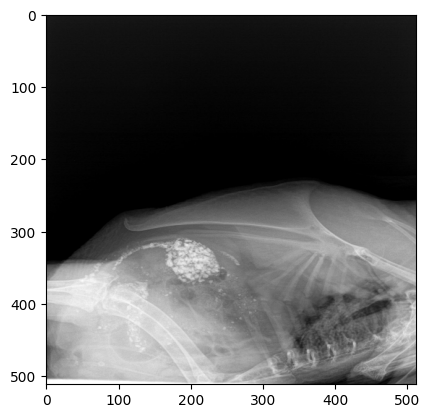

In [24]:
#imageTemplate = read_image("02023SG2055_batch2_brown_ok_4.jpg")
#imageTemplate = read_image("02023SG1843_batch2_brown_ok_4.jpg")
imageTemplate = read_image("02023SS6436_batch2_white_ok_2.jpg")


plt.imshow(imageTemplate, cmap=plt.get_cmap('gray'))

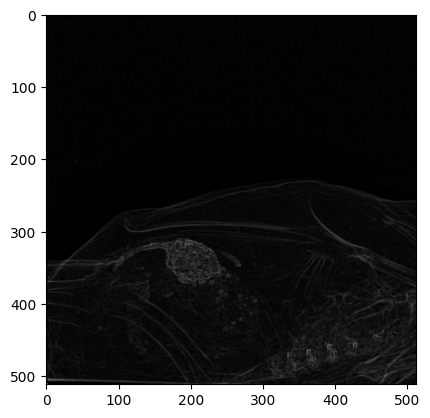

In [25]:
imageNewEdgeOperator = newEdgeOperator(imageTemplate)
plt.imshow(imageNewEdgeOperator, cmap=plt.get_cmap('gray'))

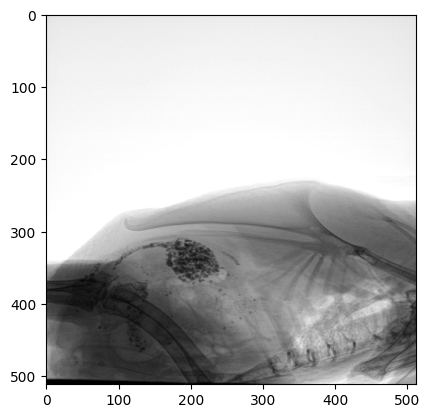

In [26]:
imageWhite = cv2.bitwise_not(imageTemplate)
plt.imshow(imageWhite, cmap=plt.get_cmap('gray'))

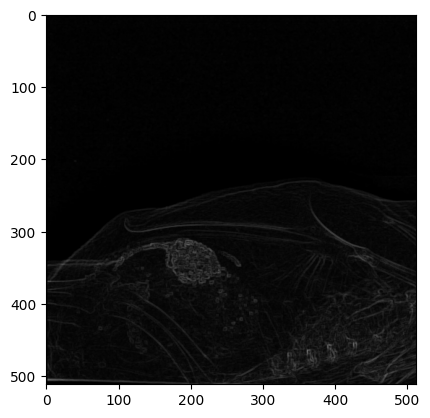

In [27]:
imageWhiteNewEdgeOperator = newEdgeOperator(imageWhite)
plt.imshow(imageWhiteNewEdgeOperator, cmap=plt.get_cmap('gray'))

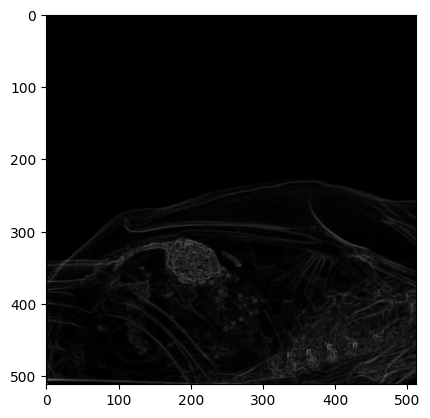

In [11]:
imageDenoised = cv2.fastNlMeansDenoising(imageTemplate)
imageNewEdgeOperatorDenoised= newEdgeOperator(imageDenoised)
plt.imshow(imageNewEdgeOperatorDenoised, cmap=plt.get_cmap('gray'))

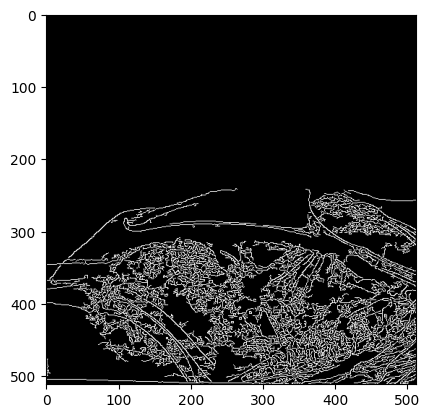

In [12]:
imageCanny = cv2.Canny(imageTemplate, 0, 170)
plt.imshow(imageCanny, cmap=plt.get_cmap('gray'))

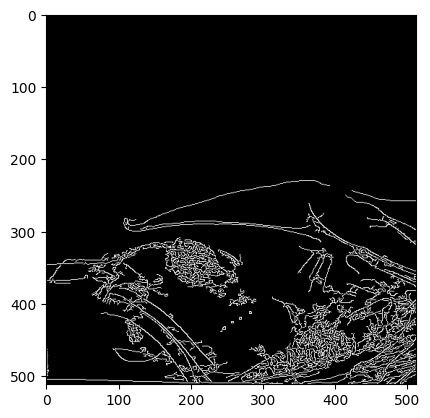

In [13]:
imageDenoised = cv2.fastNlMeansDenoising(imageTemplate)
imageCanny = cv2.Canny(imageDenoised, 0, 170)
plt.imshow(imageCanny, cmap=plt.get_cmap('gray'))

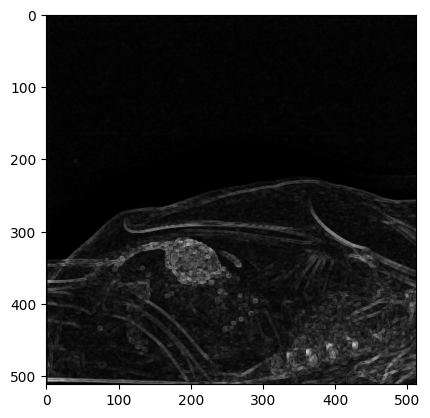

In [14]:
fourier_gaussian = scipy.ndimage.fourier_gaussian(imageTemplate, sigma=0.01)
x_prewitt = scipy.ndimage.prewitt(fourier_gaussian, axis=0)
y_prewitt = scipy.ndimage.prewitt(fourier_gaussian, axis=1)
xray_image = np.hypot(x_prewitt, y_prewitt)

imageNewEdgeOperator_fg = newEdgeOperator(xray_image)
plt.imshow(imageNewEdgeOperator_fg, cmap=plt.get_cmap('gray'))

Let's first import the common classes.

In [15]:
def computeKirsch(imge):
    """Computes and applies Kirsch operator to a given image."""
    N = imge.shape[0]
    result = np.zeros([N, N], dtype=float)
    
    #Copy the first and last rows, first and last columns
    result[0, :] = imge[0, :]
    result[:, 0] = imge[:, 0]
    result[N-1, :] = imge[N-1, :]
    result[:, N-1] = imge[:, N-1]
    
    #Kirsch Operator to the image.
    for i in np.arange(1, N-1):
        for j in np.arange(1, N-1):
            
            #Take the sub image.
            subImge = imge[i-1:i+2, j-1:j+2]
            
            #Number of elements in which Kirsch operator is applied
            n = 8
            
            #Flatten the sub image.
            subImgeFl = np.zeros(n, dtype=int)
            subImgeFl[:3] = subImge[0,:]
            subImgeFl[3] = subImge[1, -1]
            subImgeFl[4:7] = subImge[-1,:][::-1]
            subImgeFl[7] = subImge[1,0]

            #Variable that stores the maximum value
            mx = 1
            for k in np.arange(n):
                S = subImgeFl[k%n]+subImgeFl[(k+1)%n]+subImgeFl[(k+2)%n]
                T = (subImgeFl[(k+3)%n]+subImgeFl[(k+4)%n]+subImgeFl[(k+5)%n]+
                     subImgeFl[(k+6)%n]+subImgeFl[(k+7)%n])
                diff = abs((5*S)-(3*T)) 
                if diff > mx:
                    mx = diff
            result[i, j] = mx
            
    return result

In [16]:
def generateRowColumnSobelGradients():
    """Generates the x-component and y-component of Sobel operators."""
    rowGradient = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    colGradient = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    return rowGradient, colGradient

In [17]:
def computeSobel(imge):
    """Computes and applies Sobel operator to an image."""
    N = imge.shape[0]
    result = np.zeros([N, N], dtype=float)
    
    #Copy the first and last rows, first and last columns
    result[0, :] = imge[0, :]
    result[:, 0] = imge[:, 0]
    result[N-1, :] = imge[N-1, :]
    result[:, N-1] = imge[:, N-1]
    
    #Generate the Row and Column Gradients of Sober.
    rowGradient, colGradient = generateRowColumnSobelGradients()
    
    #Sober Operator to the image.
    for i in np.arange(1, N-1):
        for j in np.arange(1, N-1):
            subImge = imge[i-1:i+2, j-1:j+2]
            rowSum = np.sum(rowGradient * subImge)
            colSum = np.sum(colGradient * subImge)
            result[i, j] = math.sqrt(rowSum**2 + colSum**2)
    
    return result

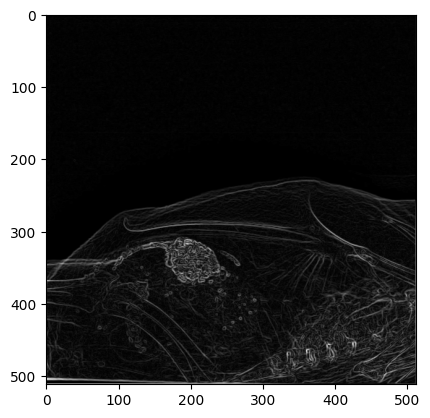

In [18]:
imageSobel = computeSobel(imageTemplate)
plt.imshow(imageSobel, cmap=plt.get_cmap('gray'))

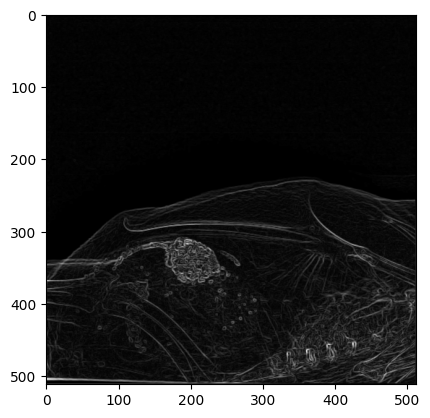

In [19]:
imageKirsch = computeKirsch(imageTemplate)
plt.imshow(imageKirsch, cmap=plt.get_cmap('gray'))

Text(0.5, 1.0, 'imageSobel')

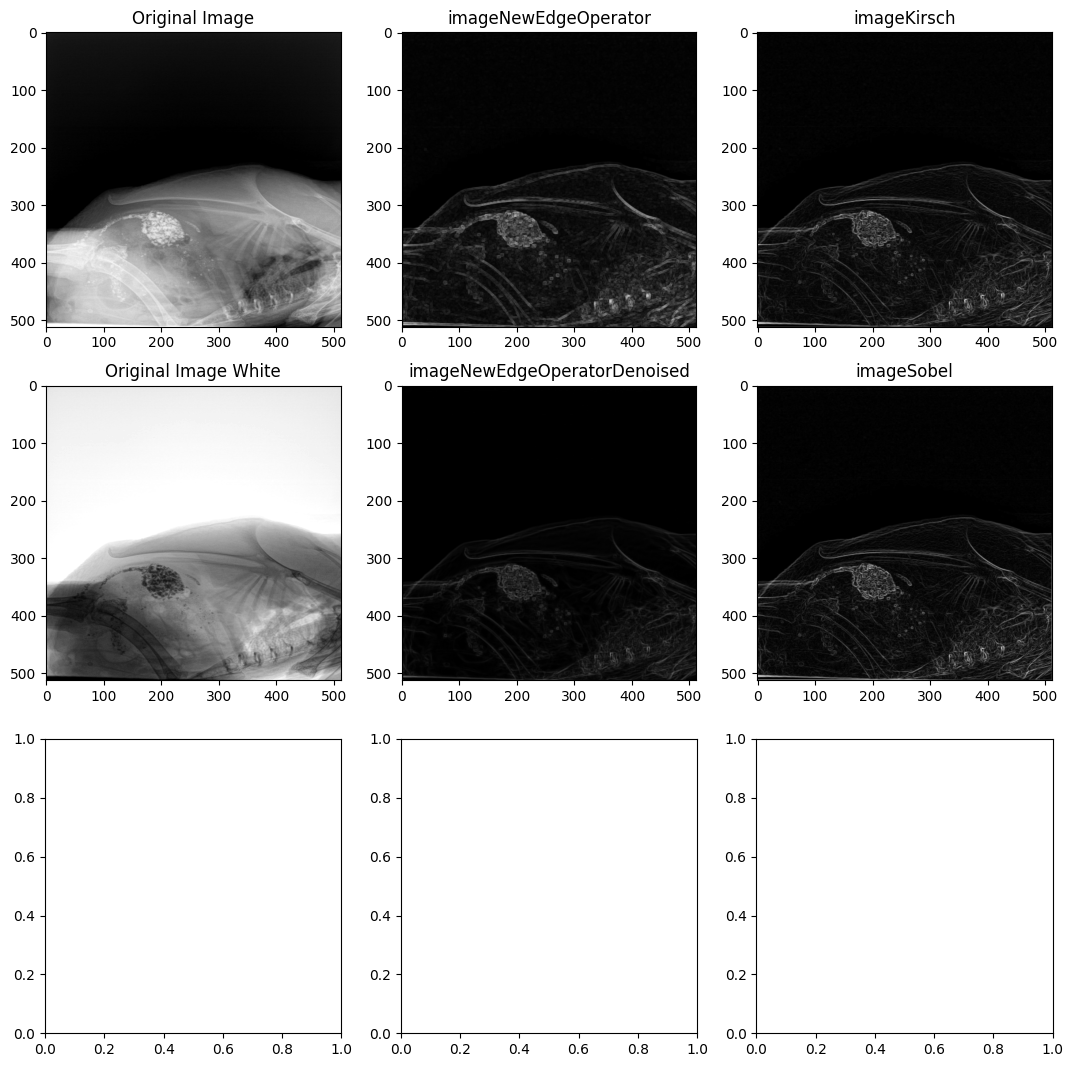

In [20]:
fig, axarr = plt.subplots(3, 3, figsize=[13,13])
axarr[0][0].imshow(imageTemplate, cmap=plt.get_cmap('gray'))
axarr[0][0].set_title('Original Image')

axarr[0][1].imshow(imageNewEdgeOperator, cmap=plt.get_cmap('gray'))
axarr[0][1].set_title('imageNewEdgeOperator')

axarr[0][2].imshow(imageKirsch, cmap=plt.get_cmap('gray'))
axarr[0][2].set_title('imageKirsch')


axarr[1][0].imshow(imageWhite, cmap=plt.get_cmap('gray'))
axarr[1][0].set_title('Original Image White')

axarr[1][1].imshow(imageNewEdgeOperatorDenoised, cmap=plt.get_cmap('gray'))
axarr[1][1].set_title('imageNewEdgeOperatorDenoised')

axarr[1][2].imshow(imageSobel, cmap=plt.get_cmap('gray'))
axarr[1][2].set_title('imageSobel')

#axarr[2][0].imshow(, cmap=plt.get_cmap('gray'))
#axarr[2][0].set_title('')
#axarr[2][1].imshow(, cmap=plt.get_cmap('gray'))
#axarr[2][1].set_title('')
#axarr[2][2].imshow(, cmap=plt.get_cmap('gray'))
#axarr[2][2].set_title('')